This notebook uses the classic Iris dataset to predict Iris species by eximining its sepal and petal lieves' length and width. 

This notebook has 2 parts: 
1. **Standard Classification Pipeline** - includes data cleaning, feature scaling, classifier selection and hyper-parameters tuning for best performance.
2. **Misclassification Analysis** - Using Scatter plots and the MAGIC tool.

Link to dataset: [here](https://archive.ics.uci.edu/ml/datasets/iris).


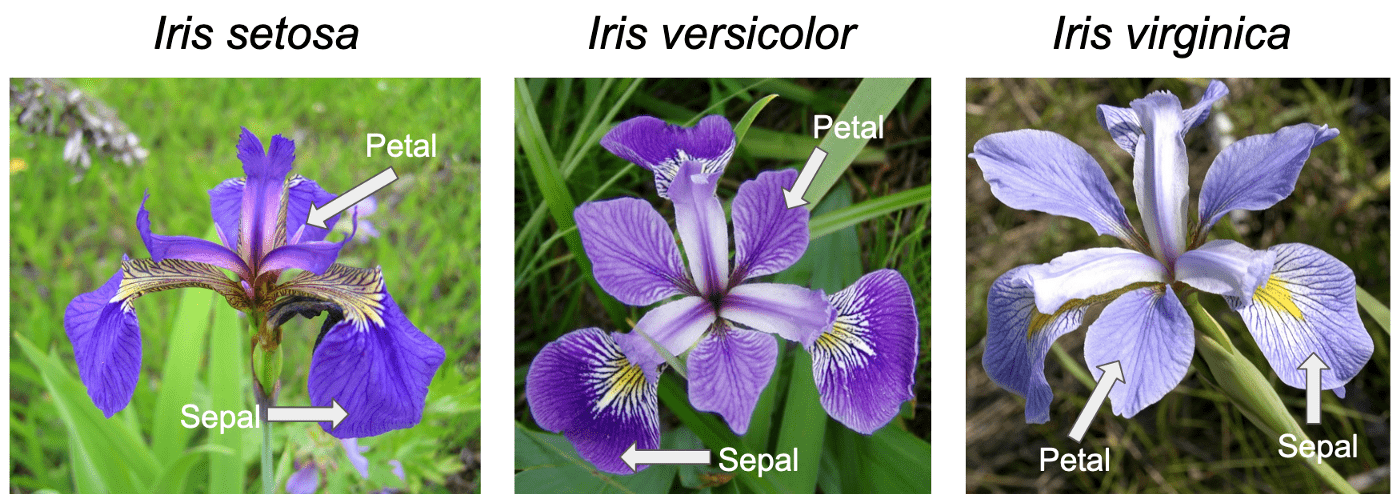

# Part 1: Standard Classification Pipeline

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris # Reference: https://stackoverflow.com/questions/38105539/how-to-convert-a-scikit-learn-dataset-to-a-pandas-dataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

## Exploratory Data Analysis

In [ ]:
iris = load_iris()

df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['Species']).astype({'Species': 'int32'})

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
df.value_counts('Species')

Species
0    50
1    50
2    50
dtype: int64

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5
Species,150.0,1.000000,0.819232,0.0,0.0,1.00,2.0,2.0


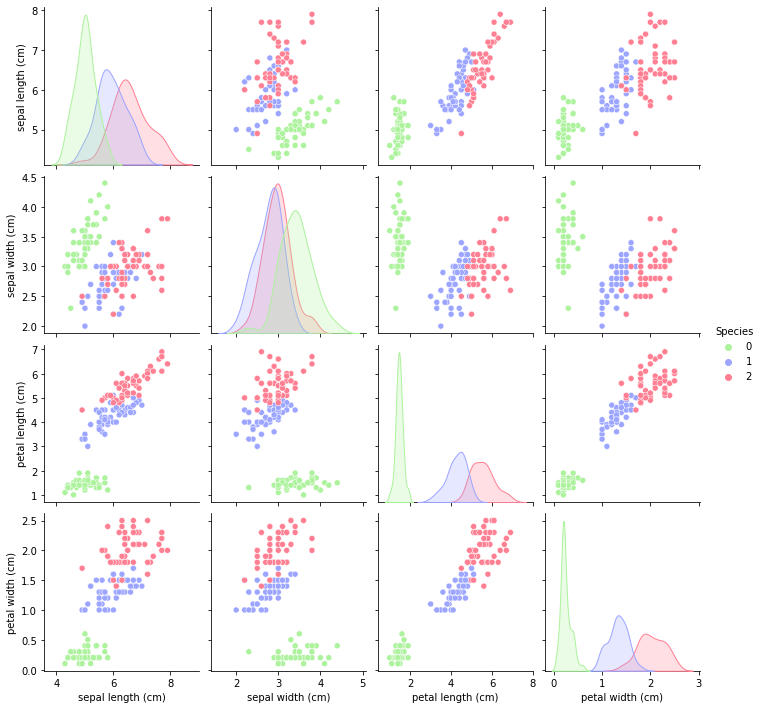

In [ ]:
sns.pairplot(df, hue="Species", palette = {0: '#adf29d', 1: '#9ca5ff', 2: '#ff8093'})

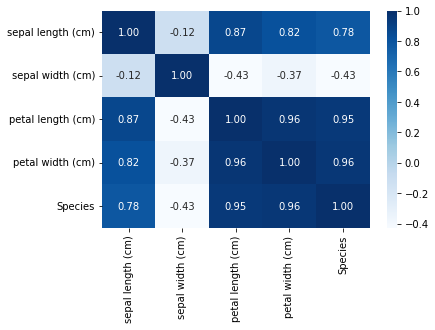

In [ ]:
corr = df.corr()
sns.heatmap(corr, annot=True,cmap='Blues',fmt='.2f')

In [ ]:
df.corr()[['Species']].sort_values('Species',ascending=False)

,Species
Species,1.000000
petal width (cm),0.956547
petal length (cm),0.949035
sepal length (cm),0.782561
sepal width (cm),-0.426658


## Prepare Train And Test Data

In [ ]:
X = df.drop(['Species'], axis=1)
y = df['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=41)

### Classifier Tuning: KNN

In [ ]:
parameters = {
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'n_neighbors': [3,5,7,9],    
              'weights' : ['uniform', 'distance']              
             }
knn11 = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
knn11.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']})

In [ ]:
knn = KNeighborsClassifier(algorithm = knn11.best_params_['algorithm'],
                           n_neighbors =  knn11.best_params_['n_neighbors'],
                           weights = knn11.best_params_['weights'])

In [ ]:
knn.fit(X_train, y_train)         
knn.score(X_test, y_test) 

0.9111111111111111

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


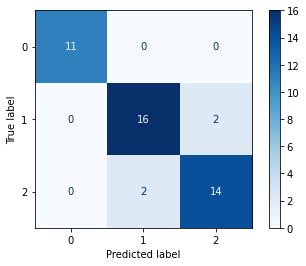

In [ ]:
plot_confusion_matrix(knn, X_test, y_test, values_format="d", cmap='Blues')

### Classifier Tuning: SVM

In [ ]:
parameters = {
              'C':[0.1, 1, 10],               
              'gamma':['scale', 'auto'],
              'kernel':('linear', 'poly','rbf', 'sigmoid')              
             }
svm11 = GridSearchCV(SVC(), parameters, cv=5)
svm11.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')})

In [ ]:
svm = SVC(kernel = svm11.best_params_['kernel'],
           C = svm11.best_params_['C'],
           gamma = svm11.best_params_['gamma'])
svm.fit(X_train, y_train)         
svm.score(X_test, y_test) 

0.9555555555555556

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


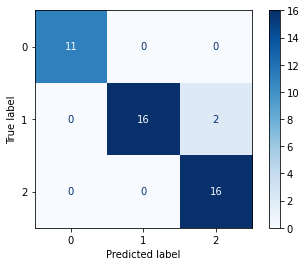

In [ ]:
plot_confusion_matrix(svm, X_test, y_test, values_format="d", cmap='Blues')

### Classifier Tuning: Conclusion

We can see that the SVM outperforms the KNN.
However, both classifiers misclassify 2 samples: two irises of speceis 1 are misclassified as 2.

In the next section we will try and analyze why using Scatter plots and the MAGIC tool.

# Part 2: Misclassification Analysis

First - let us figure out if it is the model's fault or "the data's" by comparing the svm and the knn misclassifications.

In [ ]:
predicions = knn.predict(X_test)
misclassification_index = [i for i in range(len(X_test)) if predicions[i] == 2 and y_test.iloc[i] == 1]
index_in_df = y_test.reset_index().iloc[misclassification_index]['index']
print(f'the index of the problematic sample misclassified by the knn:\n{index_in_df}')

the index of the problematic sample misclassified by the knn:
17    83
39    70
Name: index, dtype: int64


In [ ]:
predicions = svm.predict(X_test)
misclassification_index = [i for i in range(len(X_test)) if predicions[i] == 2 and y_test.iloc[i] == 1]
index_in_df = y_test.reset_index().iloc[misclassification_index]['index']
print(f'the index of the problematic sample misclassified by the svm:\n{index_in_df}')

the index of the problematic sample misclassified by the svm:
17    83
39    70
Name: index, dtype: int64


As we can see - the two misclassified samples are the same for both classifiers.

By inspecting the pairplot, the reason is very obvious - species 1 and 2 share the same plain along multiple attributes and partially overlap each other.

Let's see if we can utilize the Scatter plot and the MAGIC tool to discover this phenomenon more easily.


## 2.a Misclassification Analysis With Scatter Plot

In [ ]:
X_train1 = X_train.copy(deep = True)
y_train1 = y_train.copy(deep = True)
df1 = pd.concat([X_train1, y_train1], axis = 1)
misclassified_samples = X_test.iloc[misclassification_index].copy(deep = True)
misclassified_samples['Species'] = 'misclassified'

df1 = pd.concat([df1, misclassified_samples], axis = 0)
df1.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
65,6.7,3.1,4.4,1.4,1
80,5.5,2.4,3.8,1.1,1
140,6.7,3.1,5.6,2.4,2
83,6.0,2.7,5.1,1.6,misclassified
70,5.9,3.2,4.8,1.8,misclassified


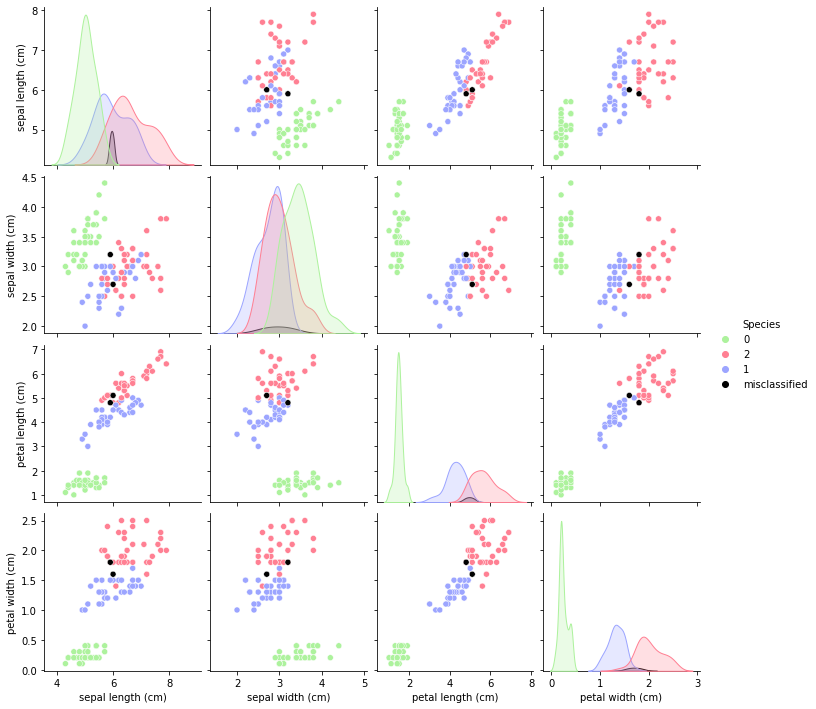

In [ ]:
sns.pairplot(df1, hue="Species", palette = {0: '#adf29d', 1: '#9ca5ff', 2: '#ff8093', 'misclassified': 'black'})

## 2.b Misclassification Anlysis With The MAGIC Tool

In [ ]:
#@title Press the run button to load the MAGIC tool

import numpy as np
import graphviz
import matplotlib.colors as mc
import re
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from PIL import Image

PRESENT_ALL = 'all'
PRESENT_VISITED = 'visited'
PRESENT_MISCLASSIFIED = 'misclassified'

##################
## Graphvitz utils

replace_words = ['<thead>', '<tbody>', '</thead>', '</tbody>', '\n', '\rn', '<table border="1" class="dataframe">',
                 '</table>']
pattern = '|'.join(replace_words)

def dataframe_to_graphviz_table(df):
    '''
    Translates a html table to graphviz format
    references:
    https://renenyffenegger.ch/notes/tools/Graphviz/attributes/label/HTML-like/index
    https://graphviz.org/Gallery/gradient/table.html
    '''
    html_table = df.to_html()
    return re.sub(pattern, '', html_table).replace('th', 'td').replace('<td>', '<td border="1" bgcolor = "white">')

def to_graphviz_format(node_header, cm):
    cm_table = dataframe_to_graphviz_table(cm)
    return '<<table border = "0">' \
           '<tr><td border = "0" colspan="3"><b>%s</b></td></tr>' \
            '%s' \
           '</table>>' % (node_header, cm_table)

####################
def create_legend (expected_label, predicted_label, expected_label_color, predicted_label_color):
    elc = color_to_hex(expected_label_color)
    plc = color_to_hex(predicted_label_color)
    return f'<<table border = "0">' \
           f'<tr><td border = "1" bgcolor= "{elc}"> expected label </td> \
                <td border = "1" bgcolor= "{plc}"> predicted label </td></tr>' \
           f'<tr><td border = "1" bgcolor= "{elc}"> {expected_label} </td> \
                <td border = "1" bgcolor= "{plc}"> {predicted_label} </td></tr>' \
           f'</table>>'

def create_cm_for_node(tp, fp, tn, fn, true_label, false_label):
    if tp == 0 and fp == 0 and tn == 0 and fn == 0:
        return None
    else:
        return pd.DataFrame({false_label: [tn, fn], true_label: [fp, tp]}, index = [false_label,true_label])

def get_nodes_visits_count_list(n_nodes, node_indicator, samples_ids):
    visits_count = [0] * n_nodes
    for sample_id in samples_ids:
        # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
        node_indexes = node_indicator.indices[
                     node_indicator.indptr[sample_id]: node_indicator.indptr[sample_id + 1]
                     ]
        for node_index in node_indexes:
            visits_count[node_index] += 1
    return visits_count

def color_to_hex(color):
    try:
        color = mc.cnames[color]
    except:
        pass
    return color

def merge_color(first_color, first_color_quantity, second_color, second_color_quantity):
    if first_color_quantity == 0 and second_color_quantity == 0:
        return 'white'
    else:
        fc = color_to_hex(first_color)
        sc = color_to_hex(second_color)
        fc_rgb = tuple(int(fc.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        sc_rgb = tuple(int(sc.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        total = first_color_quantity + second_color_quantity
        adjusted_r = round((first_color_quantity * fc_rgb[0] + second_color_quantity * sc_rgb[0]) / total)
        adjusted_g = round((first_color_quantity * fc_rgb[1] + second_color_quantity * sc_rgb[1]) / total)
        adjusted_b = round((first_color_quantity * fc_rgb[2] + second_color_quantity * sc_rgb[2]) / total)
        return '#%02x%02x%02x' % (adjusted_r, adjusted_g, adjusted_b)

def plot_misclassification_in_tree(clf, X, y, expected_label, predicted_label, expected_label_color, predicted_label_color,
                                   show_cm = True, present = PRESENT_ALL):
    y = np.array(y)  # Will be easier if y is guaranteed to be of type np array
    v = graphviz.Digraph()

    v.node(str(-1), create_legend(expected_label, predicted_label, expected_label_color, predicted_label_color),
           {'shape': 'component', 'style': 'filled', 'fillcolor': 'white'})

    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    classification = clf.predict(X)
    node_indicator = clf.decision_path(X)

    # Step 1: check how the true data traverse along the classifier
    expected_label_labeled_samples_ids = [i for i in range(len(X)) if y[i] == expected_label]
    predicted_label_labeled_samples_ids = [i for i in range(len(X)) if y[i] == predicted_label]

    expected_label_labeled_visit_count = get_nodes_visits_count_list(n_nodes, node_indicator, expected_label_labeled_samples_ids)
    predicted_label_labeled_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, predicted_label_labeled_samples_ids)

    # Step 2: inspect how the classifier would classify the samples - and create a confusion marix for it.
    true_positive_samples_ids = [i for i in range(len(X)) if
                                 y[i] == expected_label and classification[i] == expected_label]
    false_positive_samples_ids = [i for i in range(len(X)) if
                                  y[i] == predicted_label and classification[i] == expected_label]
    true_negative_samples_ids = [i for i in range(len(X)) if
                                 y[i] == predicted_label and classification[i] == predicted_label]
    false_negative_samples_ids = [i for i in range(len(X)) if
                                  y[i] == expected_label and classification[i] == predicted_label]

    tp_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, true_positive_samples_ids)
    fp_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, false_positive_samples_ids)
    tn_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, true_negative_samples_ids)
    fn_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, false_negative_samples_ids)

    if PRESENT_ALL == present:
        nodes_ids_to_plot = range(n_nodes)
    elif PRESENT_VISITED == present:
        total_visits_count = [sum(x) for x in zip(tp_visits_count, fp_visits_count, tn_visits_count, fn_visits_count)]
        nodes_ids_to_plot = [i for i in range(len(total_visits_count)) if total_visits_count[i] > 0]
    elif PRESENT_MISCLASSIFIED == present:
        nodes_ids_to_plot = [i for i in range(len(fn_visits_count)) if fn_visits_count[i] > 0]
    else:
        raise Exception('Uknown present value: %s' % present)

    for i in nodes_ids_to_plot:
        node_id = str(i)

        if children_left[i] == children_right[i]: # this is a leaf
            label = str(clf.classes_[np.argmax(clf.tree_.value[i])])
            if show_cm:
                cm = create_cm_for_node(tp_visits_count[i], fp_visits_count[i], tn_visits_count[i], fn_visits_count[i], expected_label, predicted_label)
                if cm is None:
                    node_content = label
                else:
                    node_content = to_graphviz_format(label, cm)
            else:
                node_content = label
            peripheries = '2' if fn_visits_count[i] > 0 else '1'
            fill_color = merge_color(expected_label_color, expected_label_labeled_visit_count[i], predicted_label_color, predicted_label_labeled_visits_count[i])
            v.node(node_id, node_content, {'shape': 'rect', 'style': 'filled', 'fillcolor': fill_color, 'peripheries': peripheries})

        else: # this is a split node
            node_feature = X.columns[feature[i]]
            node_tresshold = threshold[i]

            label = str(node_feature)
            if show_cm:
                cm = create_cm_for_node(tp_visits_count[i], fp_visits_count[i], tn_visits_count[i], fn_visits_count[i], expected_label, predicted_label)
                if cm is None:
                    node_content = label
                else:
                    node_content = to_graphviz_format(label, cm)
            else:
                node_content = label

            fill_color = merge_color(expected_label_color, expected_label_labeled_visit_count[i], predicted_label_color, predicted_label_labeled_visits_count[i])
            peripheries = '2' if fn_visits_count[i] > 0 else '1'
            v.node(node_id, node_content, {'shape': 'rect', 'style': 'filled', 'fillcolor': fill_color, 'peripheries': peripheries})

            if children_left[i] in nodes_ids_to_plot:
                v.edge(node_id, str(children_left[i]), node_feature + "<=" + str(round(node_tresshold, 5)))
            if children_right[i] in nodes_ids_to_plot:
                v.edge(node_id, str(children_right[i]), node_feature + ">" + str(round(node_tresshold, 5)))

    v.node(str(n_nodes), f'Total misclassification: {len(false_negative_samples_ids)}/{len(X)}',  {'shape': 'underline'}) # TODO replace with existing conut
    # v.render(directory='doctest-output', view=True, format='jpeg')
    output_path = v.render(format = 'jpg')
    im = Image.open(output_path) 
      
    # resize the image for better presentation 
    width, height = int(im.width / im.height * 1000), 1000
    im_resized = im.resize((width, height))
    return clf, im_resized

def plot_misclassification(X_train, y_train, X_test, y_test, expected_label, predicted_label, expected_label_color, predicted_label_color,
                           show_cm = True, present = PRESENT_ALL, max_depth = None):
    # Note: setting random_state to a constant number for deterministic tree creation. See: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    clf = DecisionTreeClassifier(random_state=42) if max_depth is None else  DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    return plot_misclassification_in_tree(clf, X_test, y_test, expected_label, predicted_label, expected_label_color, predicted_label_color, show_cm, present)


def extract_decision_predicate_by_path(clf, X):
    X_test = X.to_numpy()

    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    node_indicator = clf.decision_path(X_test)
    leaf_id = clf.apply(X_test)
    samples_rules_dict = {}

    for sample_id in range(len(X)):
        rules = []
        # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
        node_index = node_indicator.indices[
                     node_indicator.indptr[sample_id]: node_indicator.indptr[sample_id + 1]
                     ]

        for node_id in node_index:
            # continue to the next node if it is a leaf node
            if leaf_id[sample_id] == node_id:
                continue

            # check if value of the split feature for sample 0 is below threshold
            if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
                threshold_sign = "<="
            else:
                threshold_sign = ">"

            rules.append(f'(x[\'{X.columns[feature[node_id]]}\'] {threshold_sign} {threshold[node_id]})')

        samples_rules_dict[X.index[sample_id]] = " & ".join(rules)
    return samples_rules_dict


In [ ]:
expected_label = 1
predicted_label = 2

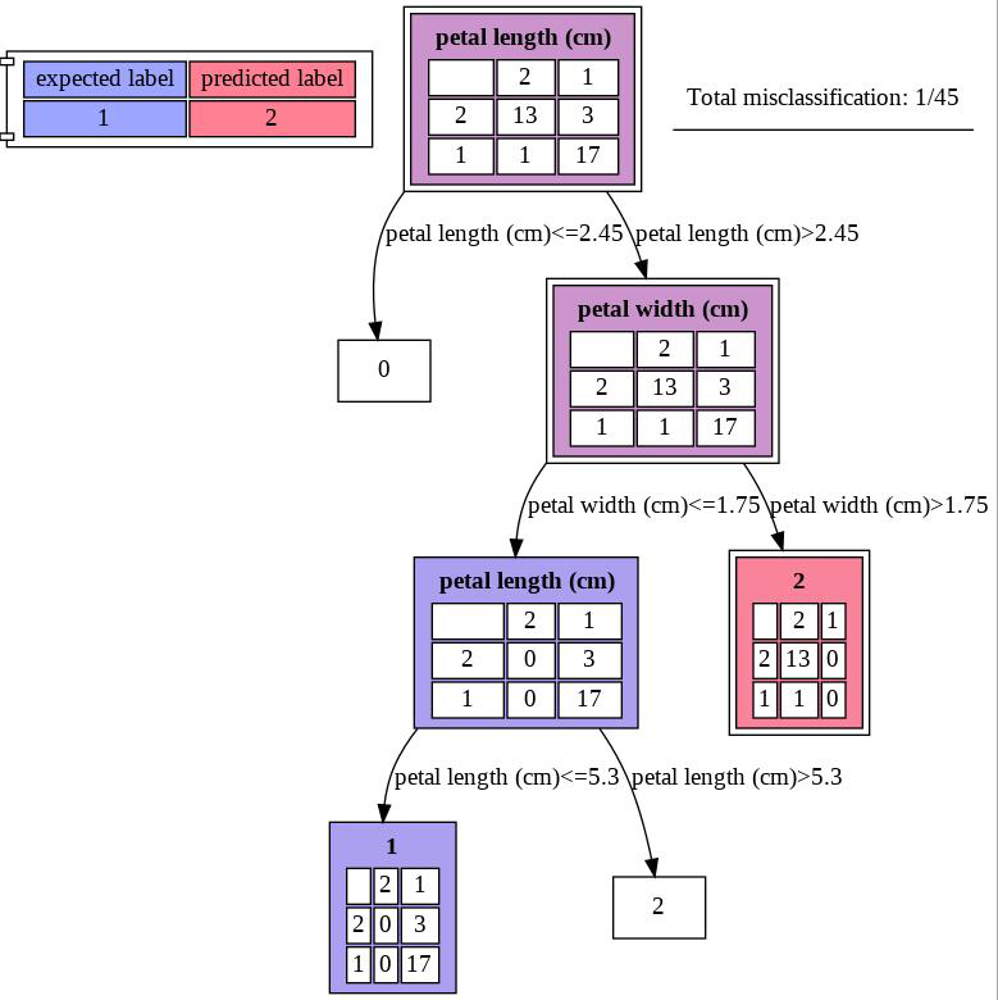

In [ ]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label, predicted_label, '#9ca5ff', '#ff8093',
                           show_cm = True, present = 'all')
plot

We can see that the tree splitted the plain better than the KNN and the SVM, yet still have a single misprediction - the same problematic sample 70:

In [ ]:
predicions = clf.predict(X_test)
misclassification_index = [i for i in range(len(X_test)) if predicions[i] == 2 and y_test.iloc[i] == 1]
index_in_df = y_test.reset_index().iloc[misclassification_index]['index']
print(f'the index of the problematic sample misclassified according to the MAGIC tool:\n{index_in_df}')

the index of the problematic sample misclassified according to the MAGIC tool:
39    70
Name: index, dtype: int64


It seems reasonable to mispredict it, as it shares the same predicate, and therefore - the same subplain, as other 13 samples of class 2 in the test-set.

# Conclusion

The MAGIC tool was very helpful in discovering the reason for the misclassification of sample 70 but failed to identify what the problem was for sample 83 which was misclassified by two classifiers - both SVM and KNN.

Therefore, the Scatter Plot is better for identifying global phenomena like overlapping palins.

The MAGIC tool is better for analyzing a single sample at a time.

<hr>

# Appendix: Illustrations For The Questionnaire

In the questionnaire, I used the tree as presented above:

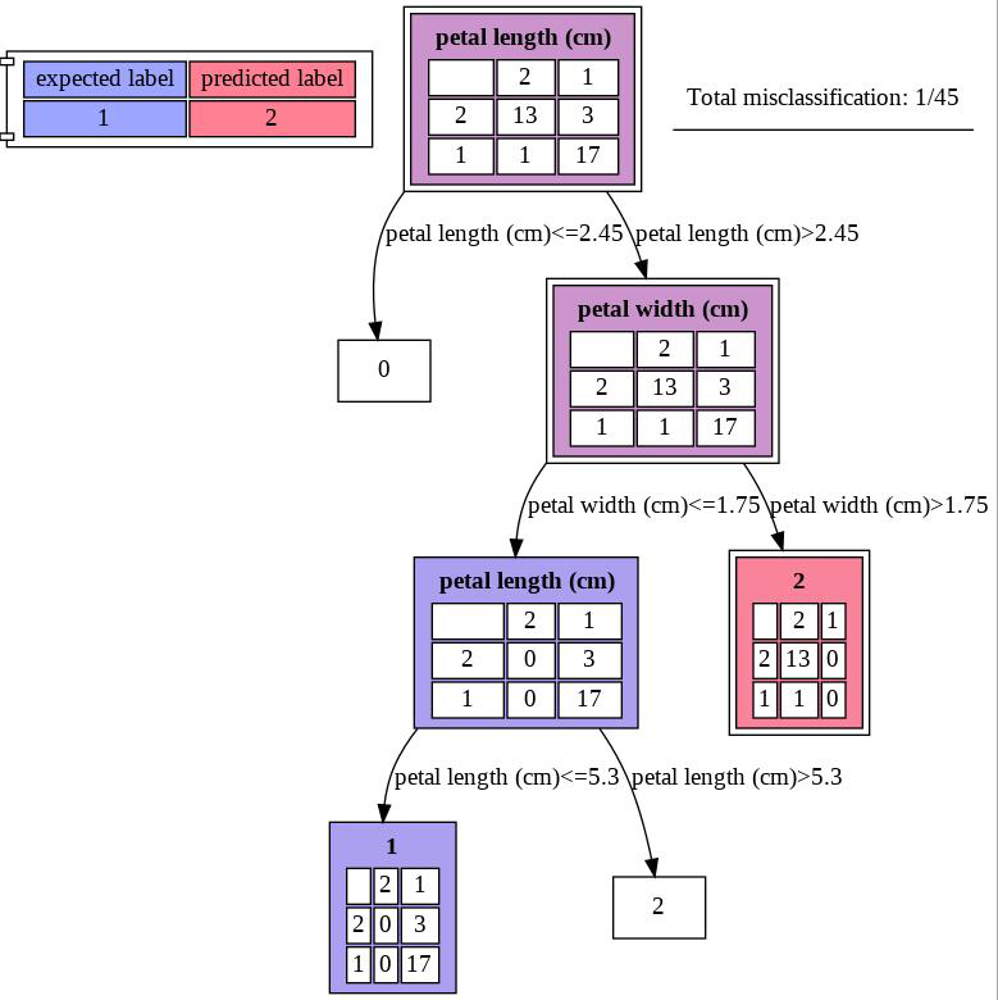

In [ ]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label, predicted_label, '#9ca5ff', '#ff8093',
                           show_cm = True, present = 'all')
plot

As for the Scatter plots, I offered all possible combination of the attributes as produced by the pairplot that also is presented in the notebook:

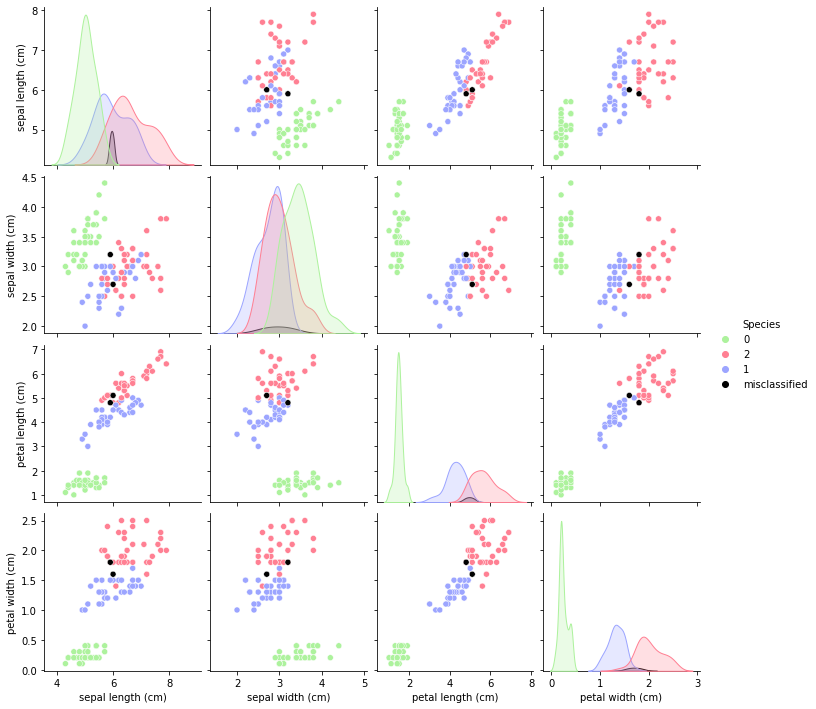

In [ ]:
sns.pairplot(df1, hue="Species", palette = {0: '#adf29d', 1: '#9ca5ff', 2: '#ff8093', 'misclassified': 'black'})